In [20]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install --upgrade xlrd
from sklearn.linear_model import LinearRegression

import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from xlrd import open_workbook
from collections import defaultdict

In [33]:
year_month = []
free_popul_sum = []


target_dir = "/content/drive/MyDrive/DL_data/DACON6/지하철 이용 정보/교통카드 통계자료/"

fname_list = os.listdir("/content/drive/MyDrive/DL_data/DACON6/지하철 이용 정보/교통카드 통계자료")
fname_list.sort(reverse=False)

for folder in tqdm.tqdm(fname_list):
    excel_list = os.listdir(target_dir+folder)
    excel_list.sort(reverse=False)
    for fname in excel_list:
        try:
            df = pd.read_excel(target_dir+folder+'/'+fname, sheet_name="지하철 유무임별 이용현황")
        except:
            continue
        df['무임승차'] = df['무임승차'].str.replace(',', '').astype(float)
        df['무임하차'] = df['무임하차'].str.replace(',', '').astype(float)

        # 무임하차 집계인원보다는 무임승차 집계인원이, 무임승차자 수와의 연관성이 높다고 판단하여 무임승차 인원으로 이용자 수 추정
        sum_fride = df['무임승차'].sum()

        year_month.append(df['사용월'][0])
        free_popul_sum.append(sum_fride)

# 2015년 4월 무임승차 정보 제거 // 데이터에 문제가 있음; 무임승차=유임하차값=무임하차 // 무임승차인원 첫 조사 시행 달이라 오류가 있던 것으로 판단
year_month = year_month[1:]
free_popul_sum = free_popul_sum[1:]

free_riders = defaultdict(list)

for i in range(len(year_month)):
    free_riders[year_month[i][:4]].append(free_popul_sum[i])

year = []
year_frider = []

for key in free_riders.keys():
    year.append(key)
    year_frider.append((sum(free_riders[key]) / len(free_riders[key]))*12)

100%|██████████| 8/8 [01:29<00:00, 11.23s/it]


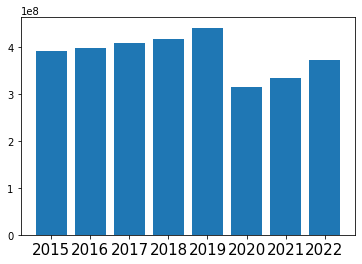

In [34]:
plt.bar(range(len(year)), year_frider)
plt.xticks(range(len(year)), year, fontsize=15)
plt.title('')
plt.show()

# 2020년 코로나로 인한 지하철 이용인원 감소

In [35]:
# 2015 - 2019 증가율을 바탕으로, 2022년부터 linear regression 적용
# Hypothesis : 2022년 이후 서울시는 코로나 사태 이후 안정기에 들어갔으므로, 기존 경향성을 유지한다.

line_fitter = LinearRegression()
line_fitter.fit(np.arange(5).reshape(-1,1), year_frider[:5])

# linear regression 절편을 2022년 데이터에 fit하도록 맞춤

gap = line_fitter.predict([[7]])[0] - year_frider[7]

line_fitter.intercept_ = line_fitter.intercept_ - gap

for y in range(2023, 2031):
    year.append(str(y))
    year_frider.append(line_fitter.predict([[y-2015]])[0])

df = pd.DataFrame(zip(year, year_frider), columns=['연도', '무임승차 인원'])

df['예측'] = [False]*8 + [True]*8 # 2015~2022는 실제 데이터, 2023~2030은 예측 데이터

In [36]:
target_dir = "/content/drive/MyDrive/DL_data/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구/"

fname_list = os.listdir("/content/drive/MyDrive/DL_data/DACON6/서울시 인구 거주/서울시 행정동 단위 생활인구/")
fname_list.sort(reverse=False)

year_ = []
total_population = []
m_btw_65_70 = []
m_upper_70 = []
w_btw_65_70 = []
w_upper_70 = []

encode = None

for fname in tqdm.tqdm(fname_list):
    if '201910' in fname:
        encode = 'cp949'
    else:
        encode = None

    df_ = pd.read_csv(target_dir+'/'+fname, engine='python', index_col=False, encoding=encode)
    df_ = df_.groupby('행정동코드').mean().sum()

    m_btw_65_70.append(df_['남자65세부터69세생활인구수'])
    m_upper_70.append(df_['남자70세이상생활인구수'])
    w_btw_65_70.append(df_['남자65세부터69세생활인구수'])
    w_upper_70.append(df_['여자70세이상생활인구수'])
    total_population.append(df_['총생활인구수'])
    year_.append(fname.split('_')[3][:4])

df_pop = pd.DataFrame(zip(year_, total_population, m_btw_65_70, m_upper_70, w_btw_65_70, w_upper_70), columns= ['년도', '총 인구', '남자 65이상70미만', '남자 70이상', '여자 65이상70미만', '여자 70이상'])

  0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py:586: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return _read(filepath_or_buffer, kwds)
100%|██████████| 61/61 [12:44<00:00, 12.53s/it]


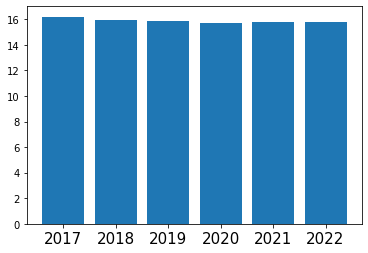

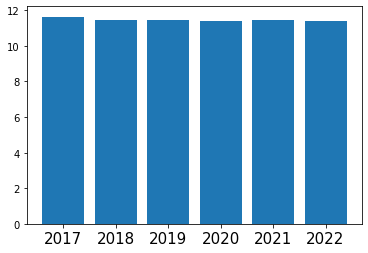

In [37]:
df_pop_year = df_pop.groupby('년도').mean()
df_pop_year = df_pop_year.reset_index()


df_pop_year['elders_ratio_thr_65'] = (df_pop['남자 65이상70미만'] + df_pop['남자 70이상'] + df_pop['여자 65이상70미만'] + df_pop['여자 70이상'])*100 / df_pop['총 인구']
df_pop_year['elders_ratio_thr_70'] = (df_pop['남자 70이상'] + df_pop['여자 70이상'])*100 / df_pop['총 인구']

plt.bar(range(len(df_pop_year)), df_pop_year['elders_ratio_thr_65'])
plt.xticks(range(len(df_pop_year)), df_pop_year['년도'], fontsize=15)
plt.title('')
plt.show()

plt.bar(range(len(df_pop_year)), df_pop_year['elders_ratio_thr_70'])
plt.xticks(range(len(df_pop_year)), df_pop_year['년도'], fontsize=15)
plt.title('')
plt.show()


## 1. 우대권 적용 연령 70세로 상향 조정시, 2023년 무임승차인원 및 손실요금 계산

In [38]:
df['case_1_fare'] = df['무임승차 인원']*(df_pop_year['elders_ratio_thr_70'].mean() / df_pop_year['elders_ratio_thr_65'].mean())*1250

## 2. 상시 운임 할인율 50%로 조정

### 할인율에 따른 인구변화 식 

할인율 $P$ % 적용 시, 철도를 이용하는 인원이 현재 무임승차 인원의 ${45 + 55*{P}/100}$ % 만큼 줄어들 것으로 산정


### 위의 식에 대한 근거
- 무임승차제도 제한에 따른 이용행태 변화전망  (354명 조사결과)

|구분|변화 없다|다른 교통수단 이용|외부활동 자제|
|:---:|:---:|:---:|:---:|
|65-69세|43.7|13.4|42.9|
|70-74세|47.0|12.8|40.2|
|75세 이상|40.2|12.0|47.9|

 제한에 연관된 `다른 교통수단 이용, 외부활동 자제` 요소를 단일변수로, `변화 없다` 요소를 상수로 보았을 때, 위와 같이 식을 단순화할 수 있음



In [39]:
P = 50

df['case_2_50_fare'] = df['무임승차 인원']*(45 + 55*P/100)*1250*P/100

## case 3 : 출퇴근 시간 동안 우대권 할인 혜택 제외

## 설명

|구분|주중|주말|일주일 고르게|
|:---:|:---:|:---:|:---:|
|65-69세|43.3|19.2|37.5|
|70-74세|50.0|12.7|37.3|
|75세 이상|40.2|12.8|47.0|



In [40]:
elder_percentage = [] 

target_dir = "/content/drive/MyDrive/DL_data/DACON6/지하철 이용 정보/서울교통공사 무임수송, 우대권 관련/15년+상반기_1_6월_역별_일별_시간대별_권종별_승하차인원"

# 특정 시간 우대권 사용자 비율 파악
fname_list = os.listdir(target_dir)
fname_list.sort(reverse=False)

for fname in fname_list:
    wb = open_workbook(target_dir+'/'+fname, logfile=open(os.devnull, 'w'))
    df_ = pd.read_excel(wb, engine='xlrd')
    df_ = df_.drop('날짜', axis=1)
    df_ = df_.rename(columns={'Unnamed: 1':'날짜'})
    df_ = df_.dropna(axis=0)

    col_list = list(df_.columns[5:len(df_.columns)-1])

    for c in col_list:
        try:
            df_[c] = df_[c].str.replace(',', '').astype(float)
        except:
            pass

    df_['날짜'] = pd.to_datetime(df_['날짜'], format='%Y-%m-%d')

    day_of_week = [0,1,2,3,4]
    extraction = ['07 ~ 08', '08 ~ 09', '09 ~ 10', '17 ~ 18', '18 ~ 19', '19 ~ 20']

    for day in day_of_week:
        df_test = df_.query('날짜.dt.dayofweek in @day_of_week')

        t_popul = df_test.iloc[:,4:29].sum()
        idx_elder = (df_test['할인'] == '우대')

        e_popul = df_test.loc[idx_elder, :]
        e_popul = e_popul.iloc[:,4:29].sum()

        t_popul = t_popul.reset_index()[1:]
        e_popul = e_popul.reset_index()[1:]

        t_popul.columns = ['시간대', '전체']
        t_popul['노인'] = e_popul[0]

        t_popul['우대/전체'] = t_popul['노인'] / t_popul['전체']

        t_popul['우대 비율'] = t_popul['노인'] / t_popul['노인'].sum()
        
    elder_percentage.append(t_popul[t_popul['시간대'].isin(extraction)]['우대 비율'].sum())

In [41]:
commute_percentage = sum(elder_percentage) / len(elder_percentage)

df['case_3_fare'] = df['무임승차 인원']*(1-commute_percentage)*1250

In [42]:
df['fare'] = df['무임승차 인원']*1250

In [43]:
df

,연도,무임승차 인원,예측,case_1_fare,case_2_50_fare,case_3_fare,fare
0,2015,392927374.5,False,3.547790e+11,1.780452e+13,3.316938e+11,4.911592e+11
1,2016,397912456.0,False,3.592801e+11,1.803041e+13,3.359021e+11,4.973906e+11
2,2017,409775569.0,False,3.699914e+11,1.856796e+13,3.459164e+11,5.122195e+11
3,2018,417788939.0,False,3.772268e+11,1.893106e+13,3.526810e+11,5.222362e+11
4,2019,441880117.0,False,3.989790e+11,2.002269e+13,3.730178e+11,5.523501e+11
5,2020,315383439.0,False,2.847636e+11,1.429081e+13,2.662343e+11,3.942293e+11
6,2021,335194905.0,False,3.026516e+11,1.518852e+13,2.829584e+11,4.189936e+11
7,2022,372105052.0,False,3.359782e+11,1.686101e+13,3.141165e+11,4.651313e+11
8,2023,383883248.8,True,3.466129e+11,1.739471e+13,3.240591e+11,4.798541e+11
9,2024,395661445.6,True,3.572476e+11,1.792841e+13,3.340018e+11,4.945768e+11
